In [1]:
N_SAMPLES = 10
SIGMA_S = [10.0, 4.0, 2.0] # s, s_dot, s_double_dot
SIGMA_D = [1.0, 1.0, 1.0]
SIGMA_T = 2.0

MAX_JERK = 10 # m/s/s/s
MAX_ACCEL= 10 # m/s/s

EXPECTED_JERK_IN_ONE_SEC = 2 # m/s/s
EXPECTED_ACC_IN_ONE_SEC = 1 # m/s

SPEED_LIMIT = 30
VEHICLE_RADIUS = 1.5 # model vehicle as circle to simplify collision detection

In [2]:
from math import sqrt, exp
from matplotlib import pyplot as plt

class Vehicle(object):
    """
    Helper class. Non-ego vehicles move w/ constant acceleration
    """
    def __init__(self, start):
        self.start_state = start
    
    def state_in(self, t):
        s = self.start_state[:3]
        d = self.start_state[3:]
        state = [
            s[0] + (s[1] * t) + s[2] * t**2 / 2.0,
            s[1] + s[2] * t,
            s[2],
            d[0] + (d[1] * t) + d[2] * t**2 / 2.0,
            d[1] + d[2] * t,
            d[2],
        ]
        return state

def logistic(x):
    """
    A function that returns a value between 0 and 1 for x in the 
    range [0, infinity] and -1 to 1 for x in the range [-infinity, infinity].

    Useful for cost functions.
    """
    return 2.0 / (1 + exp(-x)) - 1.0

def to_equation(coefficients):
    """
    Takes the coefficients of a polynomial and creates a function of
    time from them.
    """
    def f(t):
        total = 0.0
        for i, c in enumerate(coefficients): 
            total += c * t ** i
        return total
    return f

def differentiate(coefficients):
    """
    Calculates the derivative of a polynomial and returns
    the corresponding coefficients.
    """
    new_cos = []
    for deg, prev_co in enumerate(coefficients[1:]):
        new_cos.append((deg+1) * prev_co)
    return new_cos

def nearest_approach_to_any_vehicle(traj, vehicles):
    """
    Calculates the closest distance to any vehicle during a trajectory.
    """
    closest = 999999
    for v in vehicles.values():
        d = nearest_approach(traj,v)
        if d < closest:
            closest = d
    return closest

def nearest_approach(traj, vehicle):
    closest = 999999
    s_,d_,T = traj
    s = to_equation(s_)
    d = to_equation(d_)
    for i in range(100):
        t = float(i) / 100 * T
        cur_s = s(t)
        cur_d = d(t)
        targ_s, _, _, targ_d, _, _ = vehicle.state_in(t)
        dist = sqrt((cur_s-targ_s)**2 + (cur_d-targ_d)**2)
        if dist < closest:
            closest = dist
    return closest

def show_trajectory(s_coeffs, d_coeffs, T, vehicle=None):
    s = to_equation(s_coeffs)
    d = to_equation(d_coeffs)
    X = []
    Y = []
    if vehicle:
        X2 = []
        Y2 = []
    t = 0
    while t <= T+0.01:
        X.append(s(t))
        Y.append(d(t))
        if vehicle:
            s_, _, _, d_, _, _ = vehicle.state_in(t)
            X2.append(s_)
            Y2.append(d_)
        t += 0.25
    plt.scatter(X,Y,color="blue")
    if vehicle:
        plt.scatter(X2, Y2,color="red")
    plt.show()

def get_f_and_N_derivatives(coeffs, N=3):
    functions = [to_equation(coeffs)]
    for i in range(N):
        coeffs = differentiate(coeffs)
        functions.append(to_equation(coeffs))
    return functions



In [3]:
import numpy as np
# COST FUNCTIONS
def time_diff_cost(traj, target_vehicle, delta, T, predictions):
    """
    Penalizes trajectories that span a duration which is longer or 
    shorter than the duration requested.
    """
    _, _, t = traj
    return logistic(float(abs(t-T)) / T)

def s_diff_cost(traj, target_vehicle, delta, T, predictions):
    """
    Penalizes trajectories whose s coordinate (and derivatives) 
    differ from the goal.
    """
    s, _, T = traj
    target = predictions[target_vehicle].state_in(T)
    target = list(np.array(target) + np.array(delta))
    s_targ = target[:3]
    S = [f(T) for f in get_f_and_N_derivatives(s, 2)]
    cost = 0
    for actual, expected, sigma in zip(S, s_targ, SIGMA_S):
        diff = float(abs(actual-expected))
        cost += logistic(diff/sigma)
    return cost

def d_diff_cost(traj, target_vehicle, delta, T, predictions):
    """
    Penalizes trajectories whose d coordinate (and derivatives) 
    differ from the goal.
    """
    _, d_coeffs, T = traj
    
    d_dot_coeffs = differentiate(d_coeffs)
    d_ddot_coeffs = differentiate(d_dot_coeffs)

    d = to_equation(d_coeffs)
    d_dot = to_equation(d_dot_coeffs)
    d_ddot = to_equation(d_ddot_coeffs)

    D = [d(T), d_dot(T), d_ddot(T)]
    
    target = predictions[target_vehicle].state_in(T)
    target = list(np.array(target) + np.array(delta))
    d_targ = target[3:]
    cost = 0
    for actual, expected, sigma in zip(D, d_targ, SIGMA_D):
        diff = float(abs(actual-expected))
        cost += logistic(diff/sigma)
    return cost

def collision_cost(traj, target_vehicle, delta, T, predictions):
    """
    Binary cost function which penalizes collisions.
    """
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    if nearest < 2*VEHICLE_RADIUS: return 1.0
    else : return 0.0

def buffer_cost(traj, target_vehicle, delta, T, predictions):
    """
    Penalizes getting close to other vehicles.
    """
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    return logistic(2*VEHICLE_RADIUS / nearest)
    
def stays_on_road_cost(traj, target_vehicle, delta, T, predictions):
    pass

def exceeds_speed_limit_cost(traj, target_vehicle, delta, T, predictions):
    pass

def efficiency_cost(traj, target_vehicle, delta, T, predictions):
    """
    Rewards high average speeds.
    """
    s, _, t = traj
    s = to_equation(s)
    avg_v = float(s(t)) / t
    targ_s, _, _, _, _, _ = predictions[target_vehicle].state_in(t)
    targ_v = float(targ_s) / t
    return logistic(2*float(targ_v - avg_v) / avg_v)

def total_accel_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    total_acc = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        acc = a(t)
        total_acc += abs(acc*dt)
    acc_per_second = total_acc / T
    
    return logistic(acc_per_second / EXPECTED_ACC_IN_ONE_SEC )
    
def max_accel_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    all_accs = [a(float(T)/100 * i) for i in range(100)]
    max_acc = max(all_accs, key=abs)
    if abs(max_acc) > MAX_ACCEL: return 1
    else: return 0
    

def max_jerk_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk = to_equation(jerk)
    all_jerks = [jerk(float(T)/100 * i) for i in range(100)]
    max_jerk = max(all_jerks, key=abs)
    if abs(max_jerk) > MAX_JERK: return 1
    else: return 0

def total_jerk_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = to_equation(differentiate(s_d_dot))
    total_jerk = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        j = jerk(t)
        total_jerk += abs(j*dt)
    jerk_per_second = total_jerk / T
    return logistic(jerk_per_second / EXPECTED_JERK_IN_ONE_SEC )

In [4]:
import random


def PTG(start_s, start_d, target_vehicle, delta, T, predictions):
    """
    Finds the best trajectory according to WEIGHTED_COST_FUNCTIONS (global).

    arguments:
     start_s - [s, s_dot, s_ddot]

     start_d - [d, d_dot, d_ddot]

     target_vehicle - id of leading vehicle (int) which can be used to retrieve
       that vehicle from the "predictions" dictionary. This is the vehicle that 
       we are setting our trajectory relative to.

     delta - a length 6 array indicating the offset we are aiming for between us
       and the target_vehicle. So if at time 5 the target vehicle will be at 
       [100, 10, 0, 0, 0, 0] and delta is [-10, 0, 0, 4, 0, 0], then our goal 
       state for t = 5 will be [90, 10, 0, 4, 0, 0]. This would correspond to a 
       goal of "follow 10 meters behind and 4 meters to the right of target vehicle"

     T - the desired time at which we will be at the goal (relative to now as t=0)

     predictions - dictionary of {v_id : vehicle }. Each vehicle has a method 
       vehicle.state_in(time) which returns a length 6 array giving that vehicle's
       expected [s, s_dot, s_ddot, d, d_dot, d_ddot] state at that time.

    return:
     (best_s, best_d, best_t) where best_s are the 6 coefficients representing s(t)
     best_d gives coefficients for d(t) and best_t gives duration associated w/ 
     this trajectory.
    """
    target = predictions[target_vehicle]
    # generate alternative goals
    all_goals = []
    timestep = 0.5
    t = T - 4 * timestep
    while t <= T + 4 * timestep:
        target_state = np.array(target.state_in(t)) + np.array(delta)
        goal_s = target_state[:3]
        goal_d = target_state[3:]
        goals = [(goal_s, goal_d, t)]
        for _ in range(N_SAMPLES):
            perturbed = perturb_goal(goal_s, goal_d)
            goals.append((perturbed[0], perturbed[1], t))
        all_goals += goals
        t += timestep
    
    # find best trajectory
    trajectories = []
    for goal in all_goals:
        s_goal, d_goal, t = goal
        s_coefficients = JMT(start_s, s_goal, t)
        d_coefficients = JMT(start_d, d_goal, t)
        trajectories.append(tuple([s_coefficients, d_coefficients, t]))
    
    best = min(trajectories, key=lambda tr: calculate_cost(tr, target_vehicle, delta, T, predictions, WEIGHTED_COST_FUNCTIONS))
    calculate_cost(best, target_vehicle, delta, T, predictions, WEIGHTED_COST_FUNCTIONS, verbose=True)
    return best
    

def calculate_cost(trajectory, target_vehicle, delta, goal_t, predictions, cost_functions_with_weights, verbose=False):
    cost = 0
    for cf, weight in cost_functions_with_weights:
        new_cost = weight * cf(trajectory, target_vehicle, delta, goal_t, predictions)
        cost += new_cost
        if verbose:
            print("cost for {} is \t {}".format(cf.__name__, new_cost))
    return cost

def perturb_goal(goal_s, goal_d):
    """
    Returns a "perturbed" version of the goal.
    """
    new_s_goal = []
    for mu, sig in zip(goal_s, SIGMA_S):
        new_s_goal.append(random.gauss(mu, sig))

    new_d_goal = []
    for mu, sig in zip(goal_d, SIGMA_D):
        new_d_goal.append(random.gauss(mu, sig))
        
    return tuple([new_s_goal, new_d_goal])

def JMT(start, end, T):
    """
    Calculates Jerk Minimizing Trajectory for start, end and T.
    """
    a_0, a_1, a_2 = start[0], start[1], start[2] / 2.0
    c_0 = a_0 + a_1 * T + a_2 * T**2
    c_1 = a_1 + 2* a_2 * T
    c_2 = 2 * a_2
    
    A = np.array([
            [  T**3,   T**4,    T**5],
            [3*T**2, 4*T**3,  5*T**4],
            [6*T,   12*T**2, 20*T**3],
        ])
    B = np.array([
            end[0] - c_0,
            end[1] - c_1,
            end[2] - c_2
        ])
    a_3_4_5 = np.linalg.solve(A,B)
    alphas = np.concatenate([np.array([a_0, a_1, a_2]), a_3_4_5])
    return alphas

cost for time_diff_cost is 	 0.0
cost for s_diff_cost is 	 8.881784197001252e-16
cost for d_diff_cost is 	 2.6645352591003757e-15
cost for efficiency_cost is 	 0.0
cost for max_jerk_cost is 	 0
cost for total_jerk_cost is 	 0.0
cost for collision_cost is 	 0.0
cost for buffer_cost is 	 0.0
cost for max_accel_cost is 	 0
cost for total_accel_cost is 	 0.0


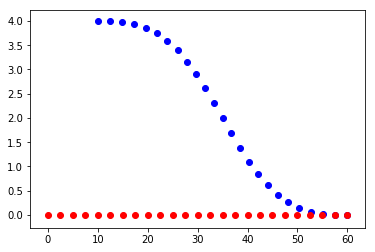

In [13]:
WEIGHTED_COST_FUNCTIONS = [
    (time_diff_cost,    0),
    (s_diff_cost,       1),
    (d_diff_cost,       1),
    (efficiency_cost,   1),
    (max_jerk_cost,     0),
    (total_jerk_cost,   0),
    (collision_cost,    0),
    (buffer_cost,       0),
    (max_accel_cost,    0),
    (total_accel_cost,  0),
]
def main():
	vehicle = Vehicle([0,10,0, 0,0,0])
	predictions = {0: vehicle}
	target = 0
	delta = [0, 0, 0, 0, 0 ,0]
	start_s = [10, 10, 0]
	start_d = [4, 0, 0]
	T = 5.0
	best = PTG(start_s, start_d, target, delta, T, predictions)
	show_trajectory(best[0], best[1], best[2], vehicle)

if __name__ == "__main__":
	main()